In [19]:
%matplotlib inline
import urllib
import matplotlib.pyplot as pp
import pylab
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.filter.matchedfilter import sigmasq
from pycbc.detector import Detector
from pycbc.psd import analytical
from pycbc.psd import read as psd_read    

def calculate_snr(param_args):
    ifos=['H1', 'L1', 'V1'] 
    sample_rate=1024

    # Create n waveforms:
    n=10
    apx='IMRPhenomD'
    distance=400 

    # masses= np.random.randint(10, 35, size=n)
    ra=2.2
    dec=-1.25
    pol=2.1 
    t_gps=120
    f_lower=10
    hp, hc=get_td_waveform(approximant=apx,
                            mass1=param_args['mass_1'],
                            mass2=param_args['mass_2'],
                            spin1z=param_args['spin_1z'],
                            spin1x=param_args['spin_1x'],
                            spin1y=param_args['spin_1y'],
                            spin2z=param_args['spin_2z'],
                            spin2x=param_args['spin_2x'],
                            spin2y=param_args['spin_2y'],
                            inclination=param_args['theta_jn'],
                            coa_phase=param_args['phase'],
                            distance=param_args['luminosity_distance'],
                            f_lower=f_lower,
                            delta_t=1.0/sample_rate)

    flow = 10.0
    delta_f = 1.0 / hp.duration 
    flen = int(sample_rate/delta_f)
    psd = analytical.aLIGOZeroDetHighPower(flen, delta_f, flow) #optimize by calculating only once
#     read_data = np.genfromtxt('o3_h1.txt')
#     psd_data = read_data[:, 1]
#     psd_data = psd_data ** 2
#     freq = read_data[:, 0]
#     psd = psd_read.from_numpy_arrays(freq, psd_data,flen, delta_f, 20)
#     psd.data[np.argwhere(psd.data == 0)] = 1
    
    gw = {'hp': hp, 'hc':hc, 'psd': psd}
    
    for ifo in ifos:
        det=Detector(ifo)
        fp, fc=det.antenna_pattern(ra, dec, pol, t_gps)
    
        s= fp * gw['hp'] + fc * gw['hc']
        snr = sigmasq(s,psd=gw['psd'], low_frequency_cutoff=10)
        if 'snr_sq' in gw:  
            gw['snr_sq'] += snr
        else:
            gw['snr_sq'] = snr
            
    return np.sqrt(gw['snr_sq'])


Text(0.5, 0, 'Mass (solar mass)')

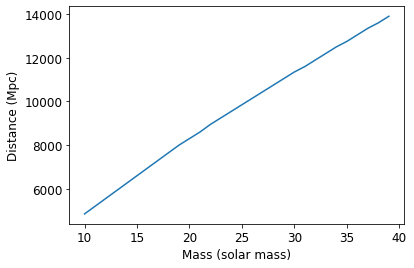

In [20]:
distance=1
masses=np.arange(10, 40, 1)
snr_ls=[]
max_distance=[]

param_args={}
param_args['spin_1z']= 0.1
param_args['spin_1x']= 0
param_args['spin_1y']= 0
param_args['spin_2z']= 0.2
param_args['spin_2x']= 0
param_args['spin_2y']= 0
param_args['theta_jn']= 2.3
param_args['phase']= 1

for mass in masses:
    while True:
        param_args['mass_1']=mass
        param_args['mass_2']=mass
        param_args['luminosity_distance']=distance
        snr = calculate_snr(param_args)
        snr_ls.append(snr)
        distance += 50
    
        if snr < 8:
            max_distance.append(distance)
            break

pylab.plot(masses, max_distance)
pylab.ylabel('Distance (Mpc)')
pylab.xlabel('Mass (solar mass)')

In [ ]:
#compute mass efficiency --> ((mass(distance it dropped - 1)/50) - 1)/((mass(distance it dropped - 1)/50))
eff = (np.array(max_distance) - 50)/np.array(max_distance)
print(eff)

In [ ]:
from astropy import cosmology
cosmo_model=cosmology.Planck15

